In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt

In [3]:
# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the last layer to match MNIST classes (10 classes)
model.fc = nn.Linear(model.fc.in_features, 10)

# Set the model to training mode and use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

c:\Users\4310129\AppData\Local\anaconda3\envs\AI417-DL\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\4310129\AppData\Local\anaconda3\envs\AI417-DL\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# Transform images to 224x224 and normalize
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the MNIST dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

In [5]:
# Define loss function and optimizer
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Learning rate scheduler to adjust the learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [6]:
# Fine-tune the model
num_epochs = 1

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Step the scheduler after each epoch
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

print('Fine-tuning complete!')

Epoch [1/1], Loss: 0.0666
Fine-tuning complete!


In [7]:
# Save the fine-tuned model
torch.save(model.state_dict(), 'finetuned_resnet18_mnist.pt')
print('Model saved!')

Model saved!


In [8]:
# Set the model to evaluation mode
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the fine-tuned model on the test images: {100 * correct / total:.2f}%')

Accuracy of the fine-tuned model on the test images: 98.71%


In [9]:
# Load the model for inference
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 10)
model.load_state_dict(torch.load('finetuned_resnet18_mnist.pt'))
model.eval()
model = model.to(device)

# Make a prediction on a single image from the test set
test_image, _ = testset[0]  # Get the first image from the test set
test_image = test_image.unsqueeze(0).to(device)  # Add a batch dimension and move to device

output = model(test_image)
_, predicted = torch.max(output, 1)

print('Predicted label:', predicted.item())

Predicted label: 7


C:\Users\4310129\AppData\Local\Temp\ipykernel_21408\2639428019.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('finetuned_resnet18_mnist

C:\Users\4310129\AppData\Local\Temp\ipykernel_21408\923407542.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('finetuned_resnet18_mnist.


Predicted label: 7


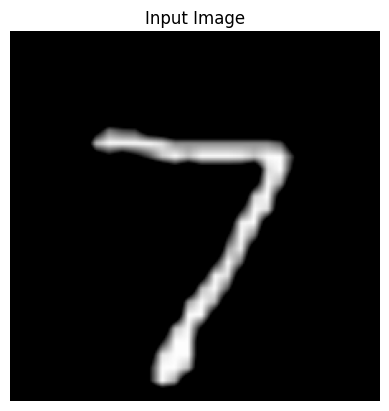

In [10]:
# Load the model for inference
model = models.resnet18()
model.fc = nn.Linear(model.fc.in_features, 10)
model.load_state_dict(torch.load('finetuned_resnet18_mnist.pt', map_location=device))
model.eval()
model = model.to(device)

# Get a single image from the test set
test_image, _ = testset[0]  # Get the first image from the test set

# Display the image
plt.imshow(test_image.permute(1, 2, 0).cpu().numpy(), cmap='gray')  # Convert tensor to NumPy and plot
plt.axis('off')
plt.title("Input Image")

# Preprocess and predict
test_image = test_image.unsqueeze(0).to(device)  # Add a batch dimension and move to device
output = model(test_image)
_, predicted = torch.max(output, 1)

print('\nPredicted label:', predicted.item())

# Show the image
plt.show()

# Task 1 - Finetuning ResNet on CIFAR-10

In [12]:
# Transform images to 224x224 and normalize
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [15:20<00:00, 185kB/s]    


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [13]:
# Load a pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the last layer to match MNIST classes (10 classes)
model.fc = nn.Linear(model.fc.in_features, 10)

# Set the model to training mode and use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [14]:
# Fine-tune the model
num_epochs = 1

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Step the scheduler after each epoch
    scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(trainloader):.4f}")

print('Fine-tuning complete!')

Epoch [1/1], Loss: 2.5756
Fine-tuning complete!


In [15]:
# Save the fine-tuned model
torch.save(model.state_dict(), 'finetuned_resnet18_cifar10.pt')
print('Model saved!')

Model saved!


In [16]:
# Set the model to evaluation mode
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the fine-tuned model on the test images: {100 * correct / total:.2f}%')

Accuracy of the fine-tuned model on the test images: 9.53%



Predicted label: 6


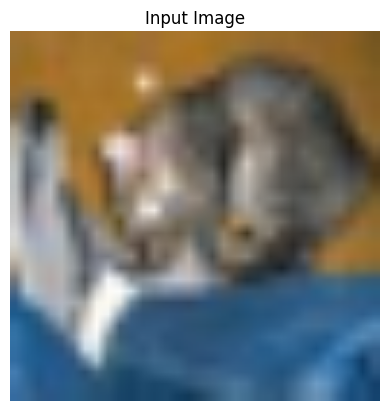

In [21]:
model.eval()
model = model.to(device)

# Get a single image from the test set
test_image, _ = testset[0]  # Get the first image from the test set
test_image = test_image * 0.5 + 0.5  # Unnormalize the image
# Display the image
plt.imshow(test_image.permute(1, 2, 0).cpu().numpy(), cmap='gray')  # Convert tensor to NumPy and plot
plt.axis('off')
plt.title("Input Image")

# Preprocess and predict
test_image = test_image.unsqueeze(0).to(device)  # Add a batch dimension and move to device
output = model(test_image)
_, predicted = torch.max(output, 1)

print('\nPredicted label:', predicted.item())

# Show the image
plt.show()